I assume you have already run `00_dataset.ipynb` and `01_tokenization.ipynb` and have the dataset format/tokenization scheme understood.

In [1]:
import torch; torch.set_grad_enabled(False);

# Model Initialization

The model is a masked autoencoder. It is a transformer encoder-decoder architecture. The encoder encodes the visible tokens, and the decoder decodes the masked tokens by using the encoder outputs as inputs. The model is trained to predict the original points from the masked tokens. The workflow is as follows:

1. Group & tokenize point cloud
2. Mask 60% of tokens randomly
3. Generate positional encodings for all centers
3. Add positional encoding onto visible tokens
4. Pass visible tokens only through encoder
5. Create a set of masked tokens equal to a single learnable mask token repeated. Add positional encoding to each masked token to tell the decoder where the masked tokens are in space.
6. Pass visible encoded tokens and masked tokens through decoder
7. Index the masked tokens in the decoder output and regress patch points from them.
8. Compare the regressed points to the ground truth points using Chamfer Distance from [`pytorch3d.loss.chamfer_distance`](https://pytorch3d.readthedocs.io/en/latest/modules/loss.html#pytorch3d.loss.chamfer_distance).

The full Point-MAE (PoLAr-MAE) model is implemented in `polarmae/models/ssl/pointmae(polarmae).py`. Both files are < 200 lines of code, and so they are hopefully straightforward to understand.

Below is the code for the PointMAE model. The magic is in the `compute_loss` method.

---

# pointmae.py

In [2]:
from typing import Any, Dict, List, Optional, Tuple

import pytorch_lightning as pl
import torch
import torch.nn as nn
from pytorch3d.loss import chamfer_distance
from math import sqrt

from polarmae.models.ssl.base import SSLModel
from polarmae.layers.encoder import TransformerEncoder
from polarmae.layers.decoder import TransformerDecoder
from polarmae.utils.pylogger import RankedLogger

log = RankedLogger(__name__, rank_zero_only=True)


class PointMAE(SSLModel):
    def __init__(
        self,
        encoder: TransformerEncoder,  # requires already initialized TransformerEncoder
        # this is taken care of by Pytorch Lightning if
        # using the CLI-based training loop.
        decoder: TransformerDecoder,  # requires already initialized TransformerDecoder
        # learning hyperparameters
        learning_rate: float = 1e-3,
        optimizer_adamw_weight_decay: float = 0.05,
        lr_scheduler_linear_warmup_epochs: int = 80,
        lr_scheduler_linear_warmup_start_lr: float = 1e-6,
        lr_scheduler_cosine_eta_min: float = 1e-6,
        lr_scheduler_stepping: str = "step",
        loss_weights: Dict[str, float] = {"ae": 0.0, "chamfer": 1.0},
        # transformations and their parameters
        # these are taken care of in the SSLModel base class via `super().configure_transformations()`
        train_transformations: List[str] = ["center_and_scale", "rotate"],
        val_transformations: List[str] = ["center_and_scale"],
        transformation_center: torch.Tensor | List[float] | float = torch.tensor(
            [768, 768, 768]
        )
        / 2,
        transformation_scale_factor: torch.Tensor | List[float] | float = 1
        / (768 * sqrt(3) / 2),
        transformation_rotate_dims: Optional[List[int]] = [0, 1, 2],
        transformation_rotate_degs: Optional[float] = None,
        # svm validation
        svm_validation: Dict[str, pl.LightningDataModule] = {},
        svm_validation_C=0.005,  # C=0.012 copied from Point-M2AE code
        svm_validation_max_tokens: int = 7500,
        # misc
        fix_estimated_stepping_batches: Optional[int] = None,  # multi GPU bug fix
    ):
        super().__init__()
        self.save_hyperparameters()
        super().configure_transformations()
        self.hparams.svm_validation = svm_validation

        self.encoder = encoder
        self.decoder = decoder

        # shared MLP that nominally goes from 384 --> 4x32, i.e., regressed a single patch from a token.
        self.increase_dim = nn.Conv1d(
            encoder.embed_dim,
            encoder.num_channels * encoder.tokenizer.grouping.group_max_points,
            1,
        )

        # learnable mask token
        init_std = 0.02
        self.mask_token = nn.Parameter(torch.zeros(encoder.embed_dim))
        nn.init.trunc_normal_(
            self.mask_token, mean=0, std=init_std, a=-init_std, b=init_std
        )

        # whether to add an autoencoding loss applied to unmasked visible tokens.
        self.do_ae = loss_weights.get("ae", 0) > 0

    def compute_loss(
        self, points: torch.Tensor, lengths: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        # encode toks
        out = self.encoder.prepare_tokens_with_masks(points, lengths)
        masked, unmasked = out["masked"], out["unmasked"]  #

        # run visible tokens through encoder, paying attention to 
        # JUST the unmasked (visible) tokens
        encoder_output = self.encoder(
            out["x"], out["pos_embed"], unmasked
        ).last_hidden_state

        # corrupt embeddings with masked tokens
        corrupted_embeddings = encoder_output * unmasked.unsqueeze(
            -1
        ) + self.mask_token * masked.unsqueeze(-1)

        # pass corrupted embeddings through decoder, paying attention
        # to ALL non-padded tokens
        decoder_output = self.decoder(
            corrupted_embeddings, out["pos_embed"], out["emb_mask"]
        ).last_hidden_state

        # Index the masked tokens in the decoder output.
        masked_output = decoder_output[masked]

        # Upscale the masked output to the original point cloud group size (32x4)
        upscaled = self.increase_dim(masked_output.transpose(0, 1)).transpose(0, 1)
        upscaled = upscaled.reshape(upscaled.shape[0], -1, self.encoder.num_channels)

        # Get the ground truth groups and point lengths for the masked tokens.
        masked_groups = out["groups"][masked]
        point_lengths = out["point_mask"][masked].sum(-1)

        # Compute the Chamfer Distance between the upscaled masked output and the ground truth groups.
        chamfer_loss, _ = chamfer_distance(
            upscaled.float(),
            masked_groups.float(),
            x_lengths=point_lengths,
            y_lengths=point_lengths,
        )

        # Do the same exercise for the unmasked tokens if we want an autoencoding loss.
        ae_loss = 0
        if self.do_ae:
            upscaled_unmasked = self.increase_dim(
                encoder_output.transpose(0, 1)
            ).transpose(0, 1)
            upscaled_unmasked = upscaled_unmasked.reshape(
                upscaled_unmasked.shape[0], -1, self.encoder.num_channels
            )
            unmasked_groups = out["groups"][unmasked]
            unmasked_point_lengths = out["point_mask"][unmasked].sum(-1)
            ae_loss, _ = chamfer_distance(
                upscaled_unmasked.float(),
                unmasked_groups.float(),
                x_lengths=unmasked_point_lengths,
                y_lengths=unmasked_point_lengths,
            )
        return {"chamfer": chamfer_loss, "ae": ae_loss}

    def training_step(self, batch, batch_idx: int) -> torch.Tensor:
        points = batch["points"]
        lengths = batch["lengths"]
        points = self.train_transformations(points)
        loss_dict = self.compute_loss(points, lengths)
        self.log_losses(loss_dict, prefix="loss/train_")
        loss = sum(
            loss_dict[k] * self.hparams.loss_weights.get(k, 1.0)
            for k in loss_dict.keys()
        )
        self.log(
            "loss/train",
            loss,
            sync_dist=True,
            on_epoch=True,
            on_step=True,
            prog_bar=True,
        )
        return loss

    def validation_step(self, batch, batch_idx: int) -> torch.Tensor:
        points = batch["points"]
        lengths = batch["lengths"]
        points = self.val_transformations(points)
        loss_dict = self.compute_loss(points, lengths)
        self.log_losses(loss_dict, prefix="loss/val_")
        loss = sum(
            loss_dict[k] * self.hparams.loss_weights.get(k, 1.0)
            for k in loss_dict.keys()
        )
        self.log("loss/val", loss, sync_dist=True, on_epoch=True, on_step=False)
        return loss

The `parse_config` function in `polarmae.utils` is used to parse the configuration file for the PointMAE model. This function reads in the YAML configuration file and automatically instantiates any classes that are defined in the configuration file (for example the encoder and decoder).

This is necessary, as the PointMAE python class requires the encoder and decoder to be initialized before it can be instantiated. This is needed for working outside of the CLI-based training loop (i.e. in a notebook).

In [3]:
from polarmae.utils import parse_config

cfg = parse_config("../configs/pointmae.yml")
model = PointMAE(**cfg["model"])

INFO:polarmae.layers.grouping:[rank: 0] Using CNMS for grouping. Using `num_groups` as the K in the ball query (256)! Make sure it's not too large!
/sdf/home/y/youngsam/sw/dune/.conda/envs/polarmae/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/sdf/home/y/youngsam/sw/dune/.conda/envs/polarmae/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


# A single forward pass.

Let's go through a single forward pass of the PointMAE model, from batch input to the final loss computation.

In [4]:
dataloader = cfg['data'].train_dataloader()

batch = next(iter(dataloader))

model = model.cuda()
points = batch["points"].cuda()
lengths = batch["lengths"].cuda()

# Apply transformations (important! performs centering and scaling)
points = model.train_transformations(points)

# Group + tokenize + mask tokens
out = model.encoder.prepare_tokens_with_masks(points, lengths)

INFO:polarmae.datasets.PILArNet:[rank: 0] self.emin=0.01, self.emax=20.0, self.energy_threshold=0.13, self.remove_low_energy_scatters=True
INFO:polarmae.datasets.PILArNet:[rank: 0] Building index
INFO:polarmae.datasets.PILArNet:[rank: 0] 1045215 point clouds were loaded
INFO:polarmae.datasets.PILArNet:[rank: 0] 10 files were loaded
INFO:polarmae.datasets.PILArNet:[rank: 0] self.emin=0.01, self.emax=20.0, self.energy_threshold=0.13, self.remove_low_energy_scatters=True
INFO:polarmae.datasets.PILArNet:[rank: 0] Building index
INFO:polarmae.datasets.PILArNet:[rank: 0] 10473 point clouds were loaded
INFO:polarmae.datasets.PILArNet:[rank: 0] 1 files were loaded


As we saw in `01_tokenization.ipynb`, the `prepare_tokens_with_masks` method returns a dictionary with the following keys:
- `x` (B, T, C): tokens
- `centers` (B, T, 3): centers of the points
- `emb_mask` (B, T): mask for the tokens
- `groups` (B, T, 32, 4): groups of the points
- `point_mask` (B, T): mask for the points
- `pos_embed` (B, T, C): positional encodings for the points

among other things for use down the line. Here, B is the batch size, T is the number of tokens, and C is the number of embedding channels.

What is actally happening in the masking step, though? Let's take a look at the `masked` and `unmasked` masks for the entire batch.

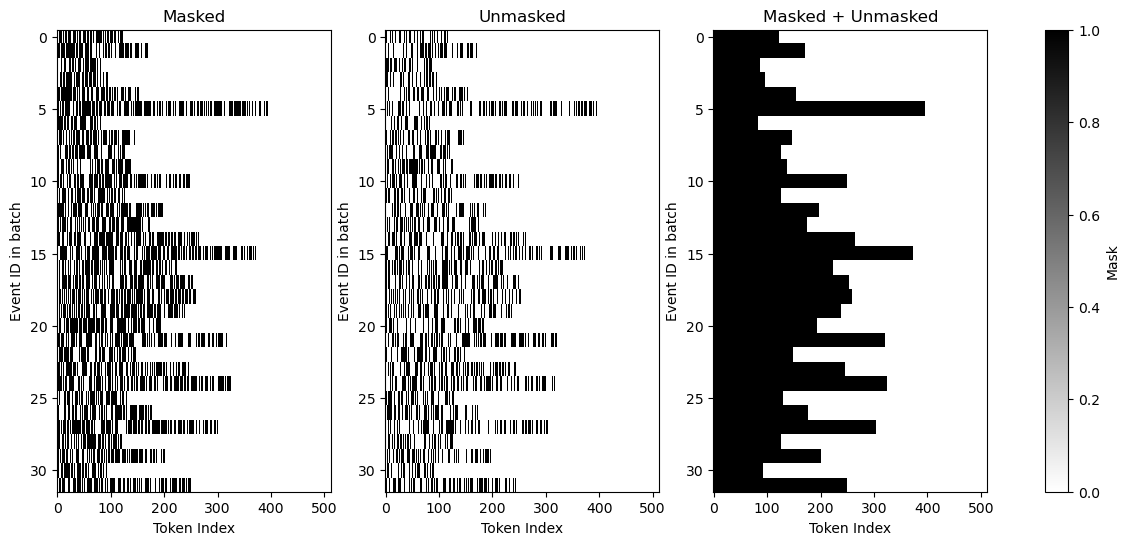

In [5]:
import matplotlib.pyplot as plt

masked, unmasked = out['masked'], out['unmasked']
embedding_mask = out['emb_mask']

# plot masked and unmasked masks for first event side by side in same figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.imshow(masked.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax1.set_title('Masked')

ax2.imshow(unmasked.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax2.set_title('Unmasked')

ax3.imshow(embedding_mask.cpu().numpy(), aspect='auto', cmap='gray_r', interpolation='none')
ax3.set_title('Masked + Unmasked')

cbar = fig.colorbar(ax3.images[0], ax=[ax1, ax2, ax3])
cbar.set_label('Mask')

ax1.set_xlabel('Token Index')
ax1.set_ylabel('Event ID in batch')
ax2.set_xlabel('Token Index')
ax2.set_ylabel('Event ID in batch')
ax3.set_xlabel('Token Index')
ax3.set_ylabel('Event ID in batch')
plt.show()


As you can see, `emb_mask = masked | unmasked`, or the total embedding mask is the union of the masked and unmasked masks.

So the masking operation is done on a per-event basis. Given the total number of tokens in an an event (which is variable within a batch), 60% of the tokens are randomly masked, while the rest are unmasked. The transformers in this repository have been modified to handle these masks directly, creating attention masks on the fly to ensure the encoder only attends to the tokens with values of 1 in the input mask.

With that being said, we can now just pass these values through the encoder / decoder. The encoder output a `TranformerOutput` object, which contains at least the last hidden state of the encoder (i.e. the final output), but can contain things like the hidden states of all the layers, the attentions, etc. These additional items are optional and accessed via additional keyword arguments for the transformer forward. To get the last hidden state, we can do the following:

In [6]:
encoder_output = model.encoder(
    out["x"], out["pos_embed"], out["unmasked"]
).last_hidden_state

print('Encoder Output Shape:', encoder_output.shape)

# Fancy trick that replaces all of masked tokens with the learnable mask token but leaves
# the unmasked tokens unchanged.
corrupted_embeddings = (
    encoder_output * out["unmasked"].unsqueeze(-1) +
    model.mask_token * out["masked"].unsqueeze(-1)
)

# Run through decoder, attending to all non-padded tokens.
decoder_output = model.decoder(
    corrupted_embeddings, out["pos_embed"], out["emb_mask"]
).last_hidden_state

print('Decoder Output Shape:', decoder_output.shape)

decoded_masked_tokens = decoder_output[out["masked"]]

print('Decoded Masked Tokens Shape:', decoded_masked_tokens.shape)

Encoder Output Shape: torch.Size([32, 512, 384])
Decoder Output Shape: torch.Size([32, 512, 384])
Decoded Masked Tokens Shape: torch.Size([3840, 384])


With the decoder output, we can now regress the decoded masked tokens to their original point groups, and compare them via the Chamfer distance. `increase_dim` is a `Conv1d` layer that takes the decoder output and upscales it to the original point group size. Because it's a convolution, we need to transpose the decoder output to have a batch dimension on the last dimension, and then transpose once again after the convolution.

In [8]:
regressed_points = model.increase_dim(decoded_masked_tokens.transpose(0, 1)).transpose(
    0, 1
)

print('Regressed Points Shape:', regressed_points.shape)

# Reshape to the point group size (32x4)
regressed_points = regressed_points.reshape(
    regressed_points.shape[0], -1, model.encoder.num_channels
)

print('Regressed Points Shape:', regressed_points.shape)

Regressed Points Shape: torch.Size([3840, 128])
Regressed Points Shape: torch.Size([3840, 32, 4])


We now have the regressed points and the ground truth points. We can now compute the Chamfer Distance between the two. However, since the patches contain a variable number of points, we need to pass the actual lengths of each patch to the Chamfer Distance function, so we don't compute the loss on the padded points.

In [9]:
from pytorch3d.loss import chamfer_distance

truth_masked_groups = out["groups"][masked]
truth_point_lengths = out["point_mask"][masked].sum(-1)

chamfer_loss, _ = chamfer_distance(
    regressed_points,
    truth_masked_groups,
    x_lengths=truth_point_lengths,
    y_lengths=truth_point_lengths,
)

print(chamfer_loss)

tensor(0.4779, device='cuda:0')


# Validation

A decent training metric to use to see if the encoder is learning good representations is to use a Support Vector Machine (SVM) to classify the tokens into different semantic classes.

The workflow is esssentially to:

1. Tokenize point cloud as usual.
2. Look at the semantic IDs of grouped points, make a sum of one-hot vectors for each group. Our training labels will be this checking if this sum is >0 for each semantic class.
3. Pass all tokens through the encoder (i.e., do no masking).
4. Train an ensemble of class-specific SVMs to classify the tokens as containing the different semantic classes.
5. Log the training and validation accuracy of the SVM.

This is implemented in the base `SSLModel` class in `polarmae/models/ssl/base.py`, as we assume any SSL model will want to use this metric for comparison.

This is automatically done at every `val_check_interval` training iterations in the `trainer` part of the configuration file.

In [10]:
.transforms

SyntaxError: invalid syntax (837454110.py, line 1)

In [11]:
# Max number of tokens to use for training/validation
# SVMs take a long time to train, so we limit the number of tokens used
# to something like 15k tokens.
max_tokens: int = model.hparams.svm_validation_max_tokens  # type: ignore

def xy(dataloader):
    x_list = []
    label_list = []

    total = (
        max_tokens
        // (
            model.encoder.tokenizer.grouping.group_max_points
            * dataloader.batch_size
        )
        if max_tokens is not None
        else None
    )
    num_labels = cfg['data'].num_seg_classes

    for i, batch in enumerate(dataloader):
        data = batch['points'].cuda()
        lengths = batch['lengths'].cuda()
        labels_batch = batch['semantic_id'].cuda()
        with torch.no_grad():
            data = model.val_transformations(data)

            # Tokenize the points
            out = model.encoder.prepare_tokens_with_masks(data, lengths, ids=labels_batch)

            # Pass through encoder & flatten across batches
            x = model.encoder.transformer(out['x'], out['pos_embed'], out['emb_mask']).last_hidden_state.reshape(-1, model.encoder.embed_dim)

            # Get the semantic IDs for each group
            semantic_ids = out['id_groups'].reshape(-1, out['id_groups'].shape[2])

            # here we do a vectorized computation to count the amount of each semantic ID per token,
            # and then make multi-class labels as 1 if the count in each class is greater than 0.
            N = semantic_ids.shape[0]  # number of groups
            D = semantic_ids.shape[1]  # numer of semantic IDs per group

            group_indices = torch.arange(N, device=semantic_ids.device).unsqueeze(1).expand(-1, D)  # Shape: (N, D)
            semantic_ids_flat = semantic_ids.reshape(-1)
            group_indices_flat = group_indices.reshape(-1)
            valid_mask = semantic_ids_flat != -1
            semantic_ids_valid = semantic_ids_flat[valid_mask]  # Shape: (K,)
            group_indices_valid = group_indices_flat[valid_mask]  # Shape: (K,)
            counts = torch.zeros((N, num_labels), dtype=torch.int64, device=semantic_ids.device)
            counts.index_add_(0, group_indices_valid, torch.nn.functional.one_hot(semantic_ids_valid, num_classes=num_labels).to(torch.int64))
            y = (counts>0).long() # Shape: (N, num_labels)
            mask_flat = out['emb_mask'].reshape(-1)
            x = x[mask_flat]
            y = y[mask_flat]
            x_list.append(x.cpu())
            label_list.append(y.cpu())
            if total is not None and i >= total:
                break

    x = torch.cat(x_list, dim=0)[:max_tokens]
    y = torch.cat(label_list, dim=0)[:max_tokens]
    return x, y

x_train, y_train = xy(cfg['data'].train_dataloader())
x_val, y_val = xy(cfg['data'].val_dataloader())
x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([15000, 384]),
 torch.Size([15000, 4]),
 torch.Size([15000, 384]),
 torch.Size([15000, 4]))

We train a One-vs-Rest SVM to classify the tokens into containing different semantic classes. To speed up training, we use PCA to reduce the dimensionality of the token embeddings from 384 to 128 dimensions.

In [12]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from pprint import pprint

# PCA down to 128 dimensions
pca = PCA(n_components=128)
x_train = pca.fit_transform(x_train)
x_val = pca.transform(x_val)
svm_C: float = model.hparams.svm_validation_C  # type: ignore
svm = OneVsRestClassifier(
    LinearSVC(C=svm_C, class_weight="balanced", random_state=0), n_jobs=y_train.shape[1]
)
svm.fit(x_train, y_train)  # type: ignore
train_report = classification_report(y_train, svm.predict(x_train), output_dict=False)
val_report = classification_report(y_val, svm.predict(x_val), output_dict=False)

/sdf/home/y/youngsam/sw/dune/.conda/envs/polarmae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/sdf/home/y/youngsam/sw/dune/.conda/envs/polarmae/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [13]:
print(val_report)
print("ID definitions:", cfg["data"].seg_class_to_category)

              precision    recall  f1-score   support

           0       0.68      0.76      0.72      5296
           1       0.85      0.80      0.82      9533
           2       0.01      0.29      0.03       176
           3       0.08      0.65      0.14       633

   micro avg       0.51      0.77      0.61     15638
   macro avg       0.40      0.62      0.43     15638
weighted avg       0.75      0.77      0.75     15638
 samples avg       0.58      0.78      0.64     15638

ID definitions: {0: 'shower', 1: 'track', 2: 'michel', 3: 'delta'}



Pretty bad! This is of course the starting point of the model. The fully trained model gives much better results :-)
___

This ends the tutorial on model training. I would encourage looking in `polarmae/models/ssl/polarmae.py` and see the changes made there. It's also less than 200 lines of code, so it should be easy to understand if this notebook makes sense.